In [1]:
import torch
import torch.nn as nn

from torchvision import datasets, transforms
from torch.utils.data import TensorDataset
from tqdm import tqdm

import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
init_std = 0.1
init_stdv = 0.1


def smooth_truncation(x, R):
    # return np.exp(-(x ** 2-R**2))/(np.exp(-(x ** 2-R**2)) + 1)
    return (torch.exp(x/(0.5*R))/(torch.exp(x/(0.5*R)) + 1) - 0.5) * R * 2

In [3]:
class Net(nn.Module):
    def __init__(self, N=1000,cut_off = 20):
        super(Net, self).__init__()
        self.particle_num = N
        self.fc1 = nn.Linear(28*28, N)
        self.fc2 = nn.Linear(N, 2, bias=False)
        self.activation = nn.Sigmoid()
        nn.init.normal_(self.fc1.weight, mean=0, std=init_std)
        nn.init.normal_(self.fc1.bias, mean=0, std=init_std)
        nn.init.normal_(self.fc2.weight, mean=0, std=init_std)
        self.cut_off = cut_off
#v4 verision of truncation
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        
        x = self.activation(x)
        
        if self.cut_off != None:
            # self.fc2.weight.data = torch.clamp(self.fc2.weight.data, min=-self.cut_off, max=self.cut_off)
            self.fc2.weight.data = smooth_truncation(self.fc2.weight.data, R = self.cut_off )
        x = self.fc2(x)/self.particle_num 
        
        return x

class FullMomentumGradientDescentWithNoisyAndWeightDecay(torch.optim.Optimizer):
    def __init__(self, params, N, lr=1e-3, lr_2=1e-1, momentum=True, gamma=0.1, weight_decay= 0.01, noise_scale=0):
        defaults = dict(lr=lr, lr_2 = lr_2, gamma=gamma, weight_decay = weight_decay, noise_scale=noise_scale,momentum=momentum)
        self.N =  N
        super(FullMomentumGradientDescentWithNoisyAndWeightDecay, self).__init__(params, defaults)
        
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            lr = group['lr']
            lr_2 = group['lr_2']
            
            weight_decay = group['weight_decay']
            noise_scale = group['noise_scale']
                
            for p_idx, p in enumerate(group['params']):
                if p.grad is None:
                    continue
                    
                grad = p.grad.data * self.N
                
                param_state = self.state[p]
                
                if group['momentum'] == True:
                    param_state = self.state[p]
                    
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.randn_like(p.data) * init_stdv 
                        # buf = param_state['momentum_buffer'] = torch.clone(grad).detach() 
                    
                    buf = param_state['momentum_buffer']
                    
                    if gamma != 0:
                        buf.add_(-gamma * lr_2, buf.data)
                        
                    buf.add_(-grad * lr_2)
                        
                    if weight_decay != 0:
                        buf.add_(-weight_decay * lr_2, p.data)
                            
                    if noise_scale != 0:
                        noise = torch.randn_like(p.data) * noise_scale * (lr_2 ** 1/2)
                        buf.data.add_(noise)          

                    p.data.add_(lr, buf)
                    # p.data.add_(buf)
                else:
                    if weight_decay != 0:
                        grad.add_(weight_decay, p.data)
                        
                    p.data.add_(-lr, grad)
                
                    if noise_scale != 0:
                        noise = torch.randn_like(p.data) * noise_scale * (lr ** 1/2)
                        p.data.add_(noise)
                
        return loss

In [4]:
train_dataset = datasets.MNIST('../data', train=True, download=True)
test_dataset =  datasets.MNIST('../data', train=False)


# Filter the train dataset to extract images with labels 4 and 6
train_label_4_idx = train_dataset.targets == 4
train_label_6_idx = train_dataset.targets == 6
train_selected_idx = train_label_4_idx | train_label_6_idx

train_selected_images = train_dataset.data[train_selected_idx]
train_selected_labels = train_dataset.targets[train_selected_idx]

# Relabel the train images with labels 4 as 0 and labels 6 as 1
train_selected_labels = torch.where(train_selected_labels == 4, torch.tensor(0), torch.tensor(1))

# Create a TensorDataset for the train set
train_dataset = TensorDataset(train_selected_images.float(), train_selected_labels)

# Filter the test dataset to extract images with labels 4 and 6
test_label_4_idx = test_dataset.targets == 4
test_label_6_idx = test_dataset.targets == 6
test_selected_idx = test_label_4_idx | test_label_6_idx

test_selected_images = test_dataset.data[test_selected_idx]
test_selected_labels = test_dataset.targets[test_selected_idx]

# Relabel the test images with labels 4 as 0 and labels 6 as 1
test_selected_labels = torch.where(test_selected_labels == 4, torch.tensor(0), torch.tensor(1))

# Create a TensorDataset for the test set
test_dataset = TensorDataset(test_selected_images.float(), test_selected_labels)

# transform=transforms.Compose([
#                        transforms.Normalize((0.1307,), (0.3081,))
#                    ])
transform=transforms.Compose([
                       transforms.Normalize((0.1289,), (0.3053,))
                   ])

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=train_selected_images.shape[0], shuffle=False)

test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=test_selected_images.shape[0], shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)

for test_data, test_target in test_loader:
    test_data, test_target = test_data.to(device), test_target.to(device)    

In [6]:
# weight_decay = 0.001

weight_decay = 1e-3

gamma = 0.1
sigma = (2) ** (1/2) * (1e-4) ** (1/2) 

lr = 0.01
lr_2 = 0.01

particle_num = 256

cut_off = 500

momentum = True

loss_type = 'MSE'

In [7]:
if loss_type == 'MSE':
    target_onehot = torch.nn.functional.one_hot(target.long())

In [8]:
output_result = True

# test_var = 'particle_num'
# # test_values = [32,64,128,256,512,1024,2048]
# test_values = [256]

# test_var = 'lr_2'
# test_values = [0.002,0.005,0.01,0.02,0.05,0.1,0.2,1]

test_var = 'momentum'
test_values = [True, False]

# test_var = 'lr_2'
# test_values = [0.1]

test_time_per_objective = 1

result_trainloss_set = []
result_L2_trainloss_set = []
result_testacc_set = []

for test_value in test_values:
    globals()[test_var] = test_value
    
    trainloss_current = []
    L2_trainloss_current = []
    testacc_current = []
    
    for test_number in tqdm(range(test_time_per_objective)):
        # Define the loss function and optimizer
        net = Net(N=particle_num,cut_off=cut_off).to(device)

        if loss_type == 'MSE':
            criterion = nn.MSELoss()
        elif loss_type == 'KL':
            criterion = nn.CrossEntropyLoss()

        optimizer = FullMomentumGradientDescentWithNoisyAndWeightDecay(net.parameters(),particle_num, momentum=momentum, lr=lr,lr_2= lr_2,
                                                               weight_decay = weight_decay, noise_scale = sigma, gamma=gamma)

        # Train the network
        T = 500
        epochs = int(T//lr)
        
        # epochs = 10000
        
        train_losses = []
        test_accs = []
        L2_train_losses = []
        
        for epoch in range(1, epochs + 1):
#             for param_group in optimizer.param_groups:
#                 param_group['lr_2'] = 1
            
            train_loss = 0.0
            net.train()

            optimizer.zero_grad()
            output = net(data)
            if loss_type == 'MSE':
                loss = criterion(output, target_onehot.float())/2
            elif loss_type == 'KL':
                loss = criterion(output, target)/2

            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)

            train_loss /= len(train_loader.dataset)
            train_losses.append(train_loss)

#             squared_sum = 0
            
#             for idx, param in enumerate(net.parameters()):
#                 if idx == 2:  # 存疑
#                     data_temp = torch.clamp(param.data, min=-cut_off,max=cut_off)
#                     squared_sum += torch.sum(data_temp ** 2) / particle_num
            
#             L2_trian_loss = train_loss + max((squared_sum - C).item(), 0) * weight_decay 

            L2_trian_loss = train_loss
            L2_train_losses.append(L2_trian_loss)

            net.eval()
            correct = 0
#             with torch.no_grad():
#                 output = net(test_data)
#                 _, predicted = torch.max(output.data, 1)
#                 correct += (predicted == test_target).sum().item()

            test_acc = correct / len(test_loader.dataset)
            test_accs.append(test_acc)
            if (epoch == 1 or epoch % 1000 == 0) and output_result:
                
                print('T: {:.3f} Train Loss: {:.6f} L2-Train Loss: {:.6f} Test Accuracy: {:.2f}%'.format(
                    epoch * lr, train_loss, L2_trian_loss, 100. * test_acc))
                
                squared_sum = 0
            
                for idx, param in enumerate(net.parameters()):
                    squared_sum += torch.sum(param.grad.data ** 2)
                        
                print('grad_l2_norm = ',squared_sum)
                
        trainloss_current.append(train_losses)
        L2_trainloss_current.append(L2_train_losses)
        testacc_current.append(test_accs)

    result_trainloss_set.append(trainloss_current)
    result_L2_trainloss_set.append(L2_trainloss_current)
    result_testacc_set.append(testacc_current)
    
    avg_trainloss_cur = np.mean(np.array(trainloss_current)[:,-500:])
    avg_L2_trainloss =  np.mean(np.array(L2_trainloss_current)[:,-500:])
    
    print('Finish test %s=%.4f'%(test_var,globals()[test_var]),
          'cutoff = %.2f'%(cut_off),
           'lr = %.3f'%(lr),
           'lr2 = %.3f'%(lr_2),
          'momentum = %.2f'%(momentum),
          'avg_trainloss=%.3e'%(avg_trainloss_cur), 
          'avg_L2_trainloss=%.3e'%(avg_L2_trainloss))

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexn\AppData\Local\Temp\ipykernel_20868\1853215584.py:62: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ..\torch\csrc\utils\python_arg_parser.cpp:1485.)
  buf.add_(-gamma * lr_2, buf.data)


T: 0.010 Train Loss: 0.250787 L2-Train Loss: 0.250787 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0002, device='cuda:0')
T: 10.000 Train Loss: 0.060288 L2-Train Loss: 0.060288 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.2900e-05, device='cuda:0')
T: 20.000 Train Loss: 0.016183 L2-Train Loss: 0.016183 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.1927e-05, device='cuda:0')
T: 30.000 Train Loss: 0.006466 L2-Train Loss: 0.006466 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.4367e-06, device='cuda:0')
T: 40.000 Train Loss: 0.005912 L2-Train Loss: 0.005912 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.3128e-06, device='cuda:0')
T: 50.000 Train Loss: 0.004478 L2-Train Loss: 0.004478 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.5842e-06, device='cuda:0')
T: 60.000 Train Loss: 0.004130 L2-Train Loss: 0.004130 Test Accuracy: 0.00%
grad_l2_norm =  tensor(7.2075e-07, device='cuda:0')
T: 70.000 Train Loss: 0.003950 L2-Train Loss: 0.003950 Test Accuracy: 0.00%
grad_l2_norm =  tensor(7.4239e-07

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:12<00:00, 132.94s/it]


Finish test momentum=1.0000 cutoff = 500.00 lr = 0.010 lr2 = 0.010 momentum = 1.00 avg_trainloss=6.035e-04 avg_L2_trainloss=6.035e-04


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

T: 0.010 Train Loss: 0.249621 L2-Train Loss: 0.249621 Test Accuracy: 0.00%
grad_l2_norm =  tensor(0.0002, device='cuda:0')
T: 10.000 Train Loss: 0.082501 L2-Train Loss: 0.082501 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.3136e-05, device='cuda:0')
T: 20.000 Train Loss: 0.037741 L2-Train Loss: 0.037741 Test Accuracy: 0.00%
grad_l2_norm =  tensor(1.2384e-05, device='cuda:0')
T: 30.000 Train Loss: 0.016912 L2-Train Loss: 0.016912 Test Accuracy: 0.00%
grad_l2_norm =  tensor(5.2904e-06, device='cuda:0')
T: 40.000 Train Loss: 0.008744 L2-Train Loss: 0.008744 Test Accuracy: 0.00%
grad_l2_norm =  tensor(2.1561e-06, device='cuda:0')
T: 50.000 Train Loss: 0.005729 L2-Train Loss: 0.005729 Test Accuracy: 0.00%
grad_l2_norm =  tensor(9.0530e-07, device='cuda:0')
T: 60.000 Train Loss: 0.004568 L2-Train Loss: 0.004568 Test Accuracy: 0.00%
grad_l2_norm =  tensor(4.7620e-07, device='cuda:0')
T: 70.000 Train Loss: 0.004047 L2-Train Loss: 0.004047 Test Accuracy: 0.00%
grad_l2_norm =  tensor(3.1013e-07

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:10<00:00, 130.38s/it]

Finish test momentum=0.0000 cutoff = 500.00 lr = 0.010 lr2 = 0.010 momentum = 0.00 avg_trainloss=2.345e-03 avg_L2_trainloss=2.345e-03


## 数据存储

In [55]:
# # data save (serialize)

# with open('data_err_tested_0603_compared_momentum_nomomentum.txt','wb')as f:
# #     pickle.dump({'err_train':err_train,'err_valid':err_valid,'predicts_list':predicts_list},f)  
#     pickle.dump({'result_trainloss_set':result_trainloss_set, 'result_L2_trainloss_set':result_L2_trainloss_set,'result_testacc_set':result_testacc_set},f)  

In [56]:
# with open('data_err_tested_0603_compared_momentum_nomomentum.txt','rb') as f:
#     data_dict = pickle.load(f)  
    
# result_trainloss_set, result_L2_trainloss_set, result_testacc_set = data_dict['result_trainloss_set'], data_dict['result_L2_trainloss_set'],data_dict['result_testacc_set']


In [57]:
# result_err_set = []
# result_loss_path_set = []

# for test_value_idx in range(test_values_num):
#     result_loss_path_curr = []
#     result_err_curr = []
#     for exp_idx in range(len(result_err_set1)):
#         result_loss_path_curr.append(result_loss_path_set1[test_value_idx][exp_idx])
#         result_err_curr.append(result_err_set1[test_value_idx][exp_idx])
        
#     for exp_idx in range(len(result_err_set2)):
#         result_loss_path_curr.append(result_loss_path_set2[test_value_idx][exp_idx])
#         result_err_curr.append(result_err_set2[test_value_idx][exp_idx])    
    
#     result_err_set.append(result_err_curr)
#     result_loss_path_set.append(result_loss_path_curr)
    

## 可视化

In [10]:
def smooth_loss(loss_array, window_size=3):
    """
    Smooths out a 1D array of loss values by replacing each value with the mean
    of itself and its neighbors, within a given window size.
    
    Args:
        loss_array (list or numpy array): 1D array of loss values to be smoothed
        window_size (int): Size of the window for computing the mean, default is 3
        
    Returns:
        smoothed_loss (numpy array): 1D array of smoothed loss values
    """
    if window_size == 0:
        return loss_array
    
    # Pad the array with zeros on either end to handle edge cases
    padded_loss = np.pad(loss_array, (window_size//2, window_size//2), mode='edge')
    
    # Compute the rolling mean of the padded array
    smoothed_loss = np.convolve(padded_loss, np.ones(window_size)/window_size, mode='valid')
    
    return smoothed_loss

In [11]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# import seaborn
# from sklearn import linear_model

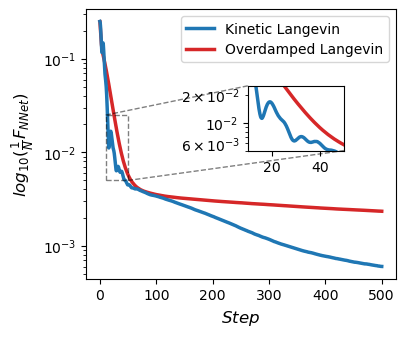

In [14]:
# log 2 loss versus interation numbers, different test var, restore the test info at first

# test_var = 'c_cutoff'
# test_values = [1,2,5,10,20]

# test_var = 'particle_num'
# try:
#     print(test_values)
# except:
#     test_values = [32,64,128,256,512]

test_var = 'momentum'
test_values = [True, False]
lr = 0.01
# test_values = [32,64,128,256,512,1024,2048]

log_wise_step = False
log_wise_loss = False
minus_minimum = False
time_xaxis = True

# colors = sns.color_palette("Paired")[1:len(test_values)+1]
colors = ['C0','C3']

fig = plt.figure(figsize=(4,3.5))
ax1 = fig.add_subplot(111)
# ax2 = fig.add_subplot(122)

axs = [ax1,]
labels = ['train\ loss', 'L2\ regularized\ train\ loss']
disvisible_index = [] # [2,4]
labels = ['Kinetic Langevin','Overdamped Langevin']

for idx, losses in enumerate([result_trainloss_set]):
    
    ax = axs[idx]

    eps = 1e-4
    smooth_window_size = 1

    axins = inset_axes(ax, width="40%", height="30%",loc='lower left',
           bbox_to_anchor=(0.5, 0.45, 0.78, 0.8),
           bbox_transform=ax.transAxes)

    axins.set_xlim(10, 50)
    axins.set_ylim(0.005, 0.025)

    for idx_ in range(len(test_values)):
        if idx_ in disvisible_index:
            continue
        I = np.array(losses[idx_]).shape[-1]
        obser_end = int(I * 1) 
        # obser_end = 200
        
        xplot_set = np.arange(I) if log_wise_loss else np.arange(I-1)
    
        globals()[test_var] = test_values[idx_]
        
        if time_xaxis == False:
            lr = 1

        xplot_set = np.log2(np.arange(1,I+1)) if log_wise_step else np.arange(I)

        for pending_list in losses[idx_]:

            yplot_set = smooth_loss(pending_list, window_size  = smooth_window_size)
            yplot_set = np.log2(yplot_set - min(yplot_set) + eps) if minus_minimum else yplot_set
            
            ax.plot(xplot_set[:obser_end]*lr,yplot_set[:obser_end],c=colors[idx_],alpha=0.05,zorder = 1)
            axins.plot(xplot_set[:obser_end]* lr,yplot_set[:obser_end],c=colors[idx_],linewidth=2.5)
        
        yplot_set = np.mean(losses[idx_],axis=0)
        yplot_set = smooth_loss(yplot_set, window_size  = smooth_window_size)
        yplot_set = np.log2(yplot_set - min(yplot_set) + eps) if minus_minimum else yplot_set

        ax.plot(xplot_set[:obser_end]* lr,yplot_set[:obser_end],linewidth = 2.5,
                 zorder = -idx_,c=colors[idx_],label=labels[idx_])
        
        # axins.plot(xplot_set[:obser_end]* lr,yplot_set[:obser_end],c=colors[idx_],linewidth=2.5)
    
    mark_inset(ax, axins,loc1=2, loc2=4, fc="none", ec='k', lw=1,linestyle='--',alpha=0.5)
    ax.legend(loc = 'upper right',ncol=1)
    ax.set_yscale('log')
    axins.set_yscale('log')
    ax.set_xlabel('$log_{10} (Step)$') if log_wise_step else ax.set_xlabel('$Step$',fontsize =12)
    ax.set_ylabel('$log_{10} (\\frac{1}{N} F_{NNet})$',fontsize=12) 
    
plt.savefig('Compared_to_GD.png', bbox_inches='tight')
plt.show()



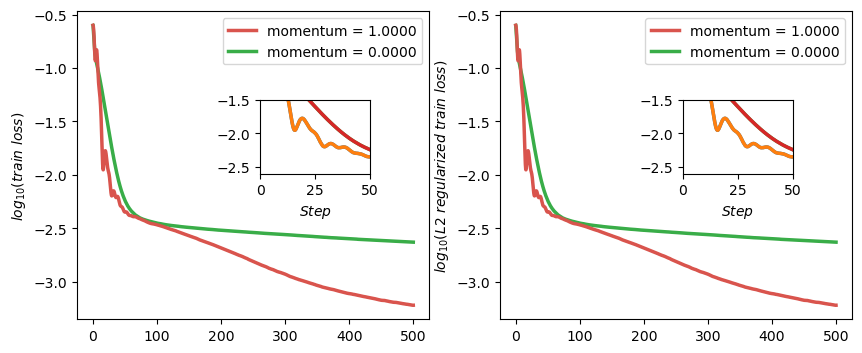

In [13]:
# log 2 loss versus interation numbers, different test var, restore the test info at first

# test_var = 'c_cutoff'
# test_values = [1,2,5,10,20]

# test_var = 'particle_num'
# try:
#     print(test_values)
# except:
#     test_values = [32,64,128,256,512]

test_var = 'momentum'
test_values = [True, False]
lr = 0.01
# test_values = [32,64,128,256,512,1024,2048]

log_wise_step = False
log_wise_loss = True
minus_minimum = False
time_xaxis = True

# colors = sns.color_palette("Paired")[1:len(test_values)+1]
colors = [sns.xkcd_rgb['pale red'],sns.xkcd_rgb['medium green'], sns.xkcd_rgb['denim blue'],'purple',sns.xkcd_rgb['orange'],'yellow','black','brown','C1']


fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

axs = [ax1,ax2]
labels = ['train\ loss', 'L2\ regularized\ train\ loss']
disvisible_index = [] # [2,4]

for idx, losses in enumerate([result_trainloss_set, result_L2_trainloss_set]):
    
    ax = axs[idx]

    eps = 1e-4
    smooth_window_size = 1

    axins = inset_axes(ax, width="40%", height="30%",loc='lower left',
           bbox_to_anchor=(0.5, 0.45, 0.78, 0.8),
           bbox_transform=ax.transAxes)

    axins.set_xlim(0, 50)
    axins.set_ylim(-2.6, -1.5)

    for idx_ in range(len(test_values)):
        if idx_ in disvisible_index:
            continue
        I = np.array(losses[idx_]).shape[-1]
        obser_end = int(I * 1) 
        # obser_end = 200
        
        xplot_set = np.arange(I) if log_wise_loss else np.arange(I-1)
    
        globals()[test_var] = test_values[idx_]
        

        
        if time_xaxis == False:
            lr = 1

        xplot_set = np.log2(np.arange(1,I+1)) if log_wise_step else np.arange(I)

        for pending_list in losses[idx_]:

            yplot_set = smooth_loss(pending_list, window_size  = smooth_window_size)
            yplot_set = np.log2(yplot_set - min(yplot_set) + eps) if minus_minimum else np.log10(yplot_set)
            
            ax.plot(xplot_set[:obser_end]*lr,yplot_set[:obser_end],c=colors[idx_],alpha=0.05,zorder = 1)
            axins.plot(xplot_set[:obser_end]* lr,yplot_set[:obser_end],linewidth=2.5)
        
        yplot_set = np.mean(losses[idx_],axis=0)
        yplot_set = smooth_loss(yplot_set, window_size  = smooth_window_size)
        yplot_set = np.log2(yplot_set - min(yplot_set) + eps) if minus_minimum else np.log10(yplot_set)

        ax.plot(xplot_set[:obser_end]* lr,yplot_set[:obser_end],linewidth = 2.5,
                 zorder = -idx_,c=colors[idx_],label='%s = %.4f'%(test_var,test_values[idx_]))
        
        
        axins.plot(xplot_set[:obser_end]* lr,yplot_set[:obser_end],linewidth=2.5)
        
    ax.legend(loc = 'upper right',ncol=1)
#     ax.set_ylim(-2,-1)
    ax.set_xlabel('$log_{10} (Step)$') if log_wise_step else plt.xlabel('$Step$')
    ax.set_ylabel('$log_{10} (%s)$'%(labels[idx])) 
    
plt.savefig('MNIST_paths.png', bbox_inches='tight')
plt.show()



## Fitting

In [18]:
from sklearn import linear_model

trained_losses = []
L2_trained_losses = []

for idx, test_vulue in enumerate(test_values):
    trained_losses_current = []
    L2_trained_losses_current = []
    
    for test_number in range(len(result_trainloss_set[idx])):
        trained_losses_current.append(np.mean(result_trainloss_set[idx][test_number][-500:]))
        L2_trained_losses_current.append(np.mean(result_L2_trainloss_set[idx][test_number][-500:]))
        
    trained_losses.append(trained_losses_current)
    L2_trained_losses.append(L2_trained_losses_current)
    


## Fixed alpha regression

In [19]:
test_time_per_objective = len(trained_losses_current)
try:
    print(test_values)
except:
    test_values = [32,64,128,256,512]

test_values = np.array([test_values])
all_data = (np.ones([test_time_per_objective,1]) * test_values).T.reshape(-1)
trained_losses = np.array(trained_losses)
L2_trained_losses =  np.array(L2_trained_losses)

model = linear_model.LinearRegression()
alpha = -1.0

model.fit(all_data.reshape(-1,1)**(alpha), trained_losses.reshape(-1))
w = model.coef_[0]
b = model.intercept_

model = linear_model.LinearRegression()
alpha_l2 = -1.0
          
model.fit(all_data.reshape(-1,1)**(alpha_l2), L2_trained_losses.reshape(-1))
w_l2 = model.coef_[0]
b_l2 = model.intercept_


[32, 64, 128, 256, 512, 1024, 2048]


## Freed alpha fit

In [14]:
from scipy.optimize import minimize


def loss(param):
    C_1 = param[0]
    C_2 = param[1]
    alpha = param[2]
    return np.mean((L2_trained_losses.reshape(-1) - C_1 - C_2 * all_data ** (alpha) )**2)

method = 'BFGS'
result = minimize(loss, x0=[0,0,0], method = method)
print(result)

b_l2, w_l2, alpha_l2 =  result.x

AttributeError: 'list' object has no attribute 'reshape'

## 可视化模组1

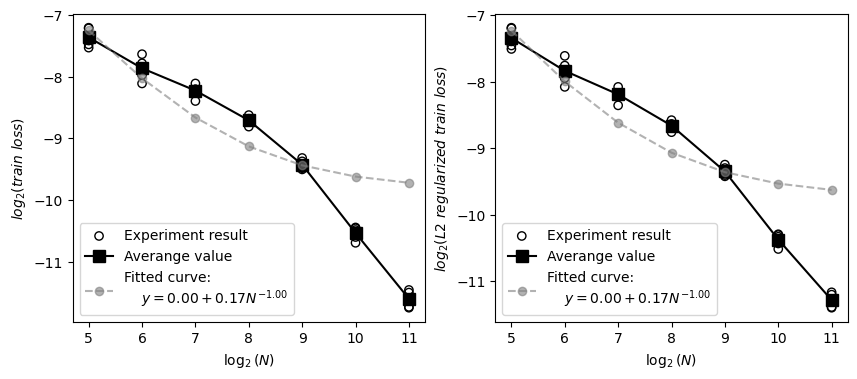

In [20]:
# log 2 terminal loss versus different test var

# test_var = 'c_cutoff'
# test_values = [1,2,5,10,20]

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

axs = [ax1,ax2]
labels = ['train\ loss', 'L2\ regularized\ train\ loss']
ws = [w, w_l2]
bs = [b, b_l2]
alphas = [alpha, alpha_l2]
logwise_loss = True


for idx, trained_losses_data in enumerate([trained_losses, L2_trained_losses]):
    ax = axs[idx]
    w_plot = ws[idx]
    b_plot = bs[idx]
    alpha_plot = alphas[idx]
    
    avg_trained_loss_vec = np.mean(trained_losses_data,axis=1)

    all_data = (np.ones([test_time_per_objective,1]) * test_values).T.reshape(-1)
    
    xplot_all = np.log2(all_data.copy()) if logwise_loss else all_data.copy()
    xplot = np.log2(test_values.reshape(-1).copy()) if logwise_loss else test_values.reshape(-1).copy()
    yplot_all = np.log2(trained_losses_data.reshape(-1).copy()) if logwise_loss else trained_losses_data.reshape(-1).copy()
    yplot =  np.log2(avg_trained_loss_vec.copy())if logwise_loss else avg_trained_loss_vec.copy()
    yplot_predict = np.log2(b_plot + w_plot * test_values.reshape(-1) ** (alpha_plot)) if logwise_loss else b_plot + w_plot * test_values.reshape(-1) ** (alpha_plot)
    
    ax.scatter(xplot_all,yplot_all,color='none',marker='o',edgecolors='k',linewidths=1,label='Experiment result')
    ax.plot(xplot,yplot,c='k',marker='s',markersize=8,label='Averange value')
    ax.plot(xplot, yplot_predict,'--', marker='o', c= 'grey', label='Fitted curve: \n    $y= %.2f + %.2f N^{%.2f}$'%(b_plot,w_plot,alpha_plot),alpha=0.6)

    ax.legend()
    
    if logwise_loss:
        ax.set_xlabel('$\log_2 (N)$')
        ax.set_ylabel('$log_2 (%s)$'%(labels[idx])) 
    else:
        ax.set_xlabel('$N$')
        ax.set_ylabel('$%s$'%(labels[idx])) 
        
plt.savefig('loss.png', bbox_inches='tight')
plt.show()


## 可视化模组2

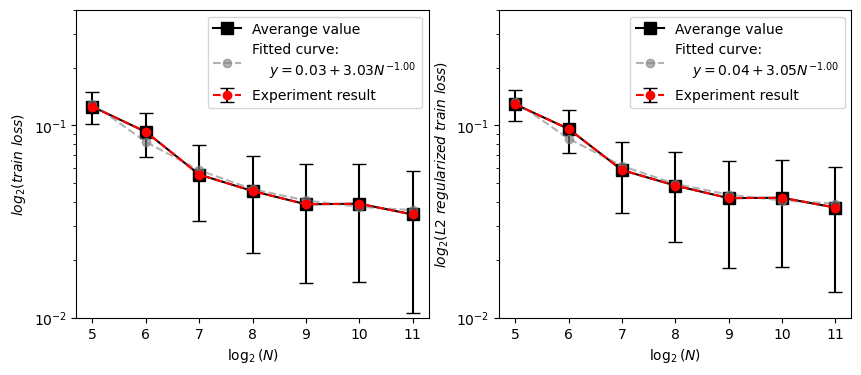

In [13]:
# log 2 terminal loss versus different test var

# test_var = 'c_cutoff'
# test_values = [1,2,5,10,20]

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

axs = [ax1,ax2]
labels = ['train\ loss', 'L2\ regularized\ train\ loss']
ws = [w, w_l2]
bs = [b, b_l2]
alphas = [alpha, alpha_l2]
logwise_loss = True


for idx, trained_losses_data in enumerate([trained_losses, L2_trained_losses]):
    ax = axs[idx]
    w_plot = ws[idx]
    b_plot = bs[idx]
    alpha_plot = alphas[idx]
    
    avg_trained_loss_vec = np.mean(trained_losses_data,axis=1)
    std_trained_loss_vec = np.std(trained_losses_data,axis=1)

    all_data = (np.ones([test_time_per_objective,1]) * test_values).T.reshape(-1)
    
    xplot = np.log2(test_values.reshape(-1).copy() )
    yplot =  avg_trained_loss_vec.copy()
    yplot_predict = b_plot + w_plot * test_values.reshape(-1) ** (alpha_plot)
    
    ax.errorbar(xplot,yplot,std_trained_loss_vec.std(),color='red', ls='--', marker='o', capsize=5, capthick=1, ecolor='black',label='Experiment result')
    ax.plot(xplot,yplot,c='k',marker='s',markersize=8,label='Averange value')
    ax.plot(xplot, yplot_predict,'--', marker='o', c= 'grey', label='Fitted curve: \n    $y= %.2f + %.2f N^{%.2f}$'%(b_plot,w_plot,alpha_plot),alpha=0.6)
    
    ax.set_yscale('log')
    ax.set_ylim(0.01,0.4)
    ax.legend()
    
    if logwise_loss:
        ax.set_xlabel('$\log_2 (N)$')
        ax.set_ylabel('$log_2 (%s)$'%(labels[idx])) 
    else:
        ax.set_xlabel('$N$')
        ax.set_ylabel('$%s$'%(labels[idx])) 
        
plt.savefig('loss.png', bbox_inches='tight')
plt.show()


In [19]:
std_trained_loss_vec

array([0.07066971, 0.04019733, 0.00739608, 0.01239414, 0.00822539])

In [8]:
particle_num = 256
criterion = nn.MSELoss()
Xai = []

for _ in tqdm(range(1000)):
    net = Net(N=particle_num,cut_off=None).to(device)
    output = net(data)
    loss = criterion(output, target_onehot.float())
    Xai.append(loss.item())
np.mean(Xai)


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 245.68it/s]


10811.407583496093

In [40]:
particle_num = 128
net = Net(N=particle_num,cut_off=cut_off).to(device)
x = torch.ones([28,28]).cuda()
net.fc1(x.view(-1)).mean(),net.fc1(x.view(-1)).std()

(tensor(1.6061, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(29.0252, device='cuda:0', grad_fn=<StdBackward0>))

In [51]:
x = torch.normal(0,4,size = [200])
x.var()

tensor(15.9758)

In [23]:
net.fc2(net.fc1(x.view(-1))).item()

RuntimeError: a Tensor with 2 elements cannot be converted to Scalar

In [65]:
x = torch.ones([28,28]).cuda()

particle_num = 128
criterion = nn.MSELoss()
Xai = []

for _ in tqdm(range(1000)):
    net = Net(N=particle_num,cut_off=None).to(device)
    Xai.append(net.fc2(net.fc1(x.view(-1)))[0].item()/particle_num)
np.mean(Xai)


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 627.25it/s]


-0.13193154431506993

In [20]:
target_onehot.shape

torch.Size([11760, 2])

In [82]:
np.mean(Xai)

19.45249426622391

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

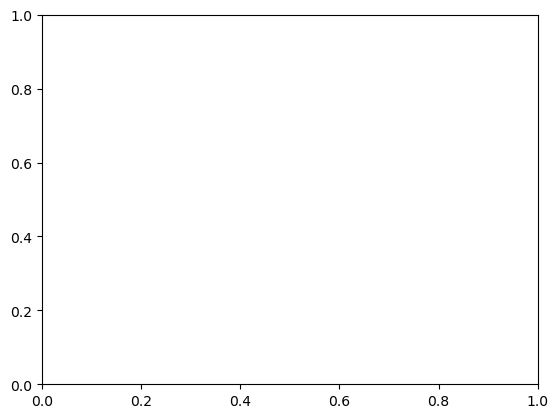

In [74]:
plt.hist(net.fc1.weight)

# CIFAR 10 deployment

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.CIFAR10('../data', train=True, transform = transform, download=True)
test_dataset =  datasets.CIFAR10('../data', train=False,  transform = transform,)

Files already downloaded and verified


In [4]:
# Filter the train dataset to extract images with labels 4 and 6
train_label_4_idx = torch.Tensor(train_dataset.targets) == 4
train_label_6_idx = torch.Tensor(train_dataset.targets) == 6
train_selected_idx = train_label_4_idx | train_label_6_idx

train_selected_images = train_dataset.data[list(train_selected_idx)]
train_selected_labels = np.array(train_dataset.targets)[list(train_selected_idx)]

# Relabel the train images with labels 4 as 0 and labels 6 as 1
train_selected_labels = np.where(train_selected_labels == 4, torch.tensor(0), torch.tensor(1))

# Create a TensorDataset for the train set
train_dataset = TensorDataset(torch.Tensor(train_selected_images), torch.Tensor(train_selected_labels))

# Filter the test dataset to extract images with labels 4 and 6
test_label_4_idx = torch.Tensor(test_dataset.targets) == 4
test_label_6_idx = torch.Tensor(test_dataset.targets) == 6
test_selected_idx = test_label_4_idx | test_label_6_idx

test_selected_images = test_dataset.data[test_selected_idx]
test_selected_labels = np.array(test_dataset.targets)[test_selected_idx]

# Relabel the test images with labels 4 as 0 and labels 6 as 1
test_selected_labels = np.where(test_selected_labels == 4, torch.tensor(0), torch.tensor(1))

# Create a TensorDataset for the test set
test_dataset = TensorDataset(torch.Tensor(test_selected_images), torch.Tensor(test_selected_labels))

# transform=transforms.Compose([
#                        transforms.Normalize((0.1307,), (0.3081,))
#                    ])

$1-e^{-\frac{1}{x^2}}$

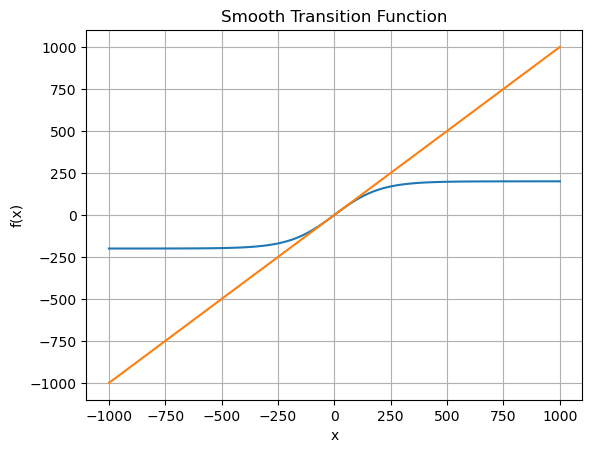

In [134]:
import numpy as np

c = 0.5
def smooth_transition(x, R):
    # return np.exp(-(x ** 2-R**2))/(np.exp(-(x ** 2-R**2)) + 1)
    return (np.exp(x/(c*R))/(np.exp(x/(c*R)) + 1) - 0.5) * R * 2


R = 200
x = np.linspace(-1000, 1000, 100)
y = smooth_transition(x, R)

import matplotlib.pyplot as plt

plt.plot(x, y)
plt.plot(x, x)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Smooth Transition Function')
plt.grid(True)
plt.show()